In [1]:

import pandas as pd
import vectorbt as vbt
from numba import njit
import numpy as np

In [2]:
vbt.settings.set_theme("dark")
file_path = '~/Documents/data/hourly_BTCUSDT.csv'
dataset = pd.read_csv(file_path, index_col=0, parse_dates=True)
data = dataset.copy()

# Resample the data
resample_freq = '18h'
data = data.resample(resample_freq).agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})

In [3]:
def get_signals(close, upper, lower, holding_period):
    signals = np.full_like(close, 0)
    signals = np.where(close > upper, 1, signals)
    signals = np.where(close < lower, -1, signals)
    # exit buy signals based on holding period
    signals = np.where((np.roll(
        signals, holding_period)==1), 2, signals) # np.roll shifts the array by the number of periods similar to pd.shift
    # exit sell signals based on holding period
    signals = np.where((np.roll(
        signals, holding_period)==-1), -2, signals) # np.roll shifts the array by the number of periods similar to pd.shift
    return signals


def channel(close, upper_threshold, lower_threshold, window, holding_period):
    std = close.pct_change().fillna(0).rolling(window).std()
    rolling_price = close.rolling(window).mean()
    upper_band = rolling_price + (std * upper_threshold * close)
    lower_band = rolling_price - (std * lower_threshold * close)
    return get_signals(close.values, upper_band.values, lower_band.values, holding_period)


breakout_ind = vbt.IndicatorFactory(
    class_name='Breakout',
    short_name='breakout',
    input_names=['close'],
    param_names=['upper_threshold', 'lower_threshold', 'window', 'holding_period'],
    output_names=['value']
).from_apply_func(
    channel, upper_threshold=2, lower_threshold=2, window=20, holding_period=25, keep_pd=True) # Changed the threshold's to reflect number of standard deviations

In [6]:
price = data['close']

In [7]:
price.shape

(2002,)

In [8]:
split_kwargs = dict(
    n=60, # Split the data into n chunks 
    window_len=1500, # Rolling window length to train set
    set_lens=(300,), # Validation set length so total window_len - set_lens = train set length
    left_to_right=False
)  # split the data into 60 chunks of 1000 bars each, with the last 300 bars being the validation set

# Set up any specific parameters for the strategy
pf_kwargs = dict(
    # direction='both',  # long and short commented out because we explicitly set the direction in the strategy
    freq=resample_freq,  # resample frequency
)


In [9]:
def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

In [10]:
roll_in_and_out_samples(price, **split_kwargs, plot=True, trace_names=['in-sample', 'out-sample']).show()

/Users/ericervin/opt/anaconda3/envs/backtesting/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [11]:
(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(price, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(1200, 60) 60
(300, 60) 60


In [12]:
def simulate_holding(price, **kwargs):
    pf = vbt.Portfolio.from_holding(price, **kwargs)
    return pf.trades.win_rate()

In [13]:
in_hold_sharpe = simulate_holding(in_price, **pf_kwargs)

print(in_hold_sharpe)

split_idx
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
39    1.0
40    1.0
41    1.0
42    1.0
43    1.0
44    1.0
45    1.0
46    1.0
47    0.0
48    0.0
49    0.0
50    0.0
51    0.0
52    0.0
53    0.0
54    0.0
55    0.0
56    0.0
57    0.0
58    0.0
59    0.0
Name: win_rate, dtype: float64


In [14]:
def simulate_all_params(price, **kwargs):
    ind1, ind2 = breakout_ind.run_combs(
        price,
        upper_threshold=np.arange(1, 3, 0.5),
        lower_threshold=np.arange(1, 3,0.5),
        window=np.arange(25,45, 5),
        holding_period=np.arange(30, 50, 5),
        param_product=True, # Cartesian product of parameters
    )

    entries = ind1.value_crossed_above(0)
    exits = ind1.value_crossed_above(1)
    entries_short = ind2.value_crossed_below(0)
    exits_short = ind2.value_crossed_below(-1)

    # # Calculate Portfolio
    pf = vbt.Portfolio.from_signals(
        close=price,
        entries=entries,
        exits=exits,
        short_entries=entries_short,
        short_exits=exits_short,
        **kwargs,
    )
    return pf.trades.win_rate()

In [15]:
in_sharpe = simulate_all_params(in_price, **pf_kwargs)

: 

: 

In [ ]:
print(in_sharpe)

breakout_1_upper_threshold  breakout_1_lower_threshold  breakout_1_window  breakout_1_holding_period  breakout_2_upper_threshold  breakout_2_lower_threshold  breakout_2_window  breakout_2_holding_period  split_idx
1.0                         1.0                         25                 30                         1.0                         1.0                         25                 35                         0            0.550000
                                                                                                                                                                                                            1            0.631579
                                                                                                                                                                                                            2            0.666667
                                                                                                            

In [ ]:
def get_best_index(performance, higher_better=True):
    if higher_better:
        return performance[performance.groupby('split_idx').idxmax()].index
    return performance[performance.groupby('split_idx').idxmin()].index

In [ ]:
in_best_index = get_best_index(in_sharpe)

print(in_best_index)

MultiIndex([(1.0, 2.0, 30, 40, 1.5, 2.5, 30, 30,  0),
            (2.0, 1.0, 30, 40, 2.5, 1.5, 40, 35,  1),
            (1.0, 1.5, 35, 30, 1.5, 1.0, 25, 45,  2),
            (1.5, 2.5, 35, 30, 2.5, 1.5, 40, 35,  3),
            (1.5, 2.5, 35, 30, 2.5, 1.5, 40, 35,  4),
            (1.0, 1.5, 25, 45, 1.5, 1.0, 35, 45,  5),
            (1.0, 1.5, 25, 45, 1.5, 1.0, 35, 45,  6),
            (1.0, 1.5, 25, 45, 1.5, 1.0, 35, 45,  7),
            (1.0, 1.5, 25, 45, 1.0, 2.0, 30, 40,  8),
            (1.0, 2.0, 30, 45, 1.0, 2.5, 25, 40,  9),
            (2.0, 1.0, 40, 35, 2.5, 1.0, 25, 30, 10),
            (1.5, 1.0, 25, 45, 2.0, 1.0, 25, 30, 11),
            (1.0, 2.0, 25, 40, 1.0, 2.0, 35, 40, 12),
            (1.0, 2.0, 30, 45, 1.0, 2.5, 25, 40, 13),
            (2.0, 1.5, 25, 45, 2.5, 1.0, 25, 30, 14),
            (2.0, 1.0, 25, 45, 2.0, 1.0, 30, 30, 15),
            (2.0, 1.0, 30, 45, 2.5, 1.0, 25, 30, 16),
            (2.0, 1.0, 25, 45, 2.0, 1.0, 30, 30, 17),
            (2.0, 1.0, 25, 4

In [ ]:
def get_best_params(best_index, level_name):
    return best_index.get_level_values(level_name).to_numpy()

In [ ]:
in_ind1_best_upper_thresholds      =get_best_params(in_best_index, 'breakout_1_upper_threshold')
in_ind1_best_lower_thresholds      =get_best_params(in_best_index, 'breakout_1_lower_threshold')
in_ind1_best_windows               =get_best_params(in_best_index, 'breakout_1_window')
in_ind1_best_hold_periods          =get_best_params(in_best_index, 'breakout_1_holding_period')
in_ind2_best_upper_thresholds      =get_best_params(in_best_index, 'breakout_2_upper_threshold')
in_ind2_best_lower_thresholds      =get_best_params(in_best_index, 'breakout_2_lower_threshold')
in_ind2_best_windows               =get_best_params(in_best_index, 'breakout_2_window')
in_ind2_best_hold_periods          =get_best_params(in_best_index, 'breakout_2_holding_period')

# zip the best parameters together
in_best_params = np.array(list(zip(in_ind1_best_upper_thresholds, in_ind1_best_lower_thresholds, in_ind1_best_windows, in_ind1_best_hold_periods, in_ind2_best_upper_thresholds, in_ind2_best_lower_thresholds, in_ind2_best_windows, in_ind2_best_hold_periods)))
print(in_best_params)

[[ 1.   2.  30.  40.   1.5  2.5 30.  30. ]
 [ 2.   1.  30.  40.   2.5  1.5 40.  35. ]
 [ 1.   1.5 35.  30.   1.5  1.  25.  45. ]
 [ 1.5  2.5 35.  30.   2.5  1.5 40.  35. ]
 [ 1.5  2.5 35.  30.   2.5  1.5 40.  35. ]
 [ 1.   1.5 25.  45.   1.5  1.  35.  45. ]
 [ 1.   1.5 25.  45.   1.5  1.  35.  45. ]
 [ 1.   1.5 25.  45.   1.5  1.  35.  45. ]
 [ 1.   1.5 25.  45.   1.   2.  30.  40. ]
 [ 1.   2.  30.  45.   1.   2.5 25.  40. ]
 [ 2.   1.  40.  35.   2.5  1.  25.  30. ]
 [ 1.5  1.  25.  45.   2.   1.  25.  30. ]
 [ 1.   2.  25.  40.   1.   2.  35.  40. ]
 [ 1.   2.  30.  45.   1.   2.5 25.  40. ]
 [ 2.   1.5 25.  45.   2.5  1.  25.  30. ]
 [ 2.   1.  25.  45.   2.   1.  30.  30. ]
 [ 2.   1.  30.  45.   2.5  1.  25.  30. ]
 [ 2.   1.  25.  45.   2.   1.  30.  30. ]
 [ 2.   1.  25.  45.   2.5  1.  25.  45. ]
 [ 2.   1.  25.  45.   2.   1.  30.  30. ]
 [ 2.5  1.  40.  45.   2.5  2.5 40.  40. ]
 [ 2.5  1.5 35.  45.   2.5  2.5 40.  40. ]
 [ 1.5  2.  40.  45.   2.5  1.  25.  30. ]
 [ 2.   1.5

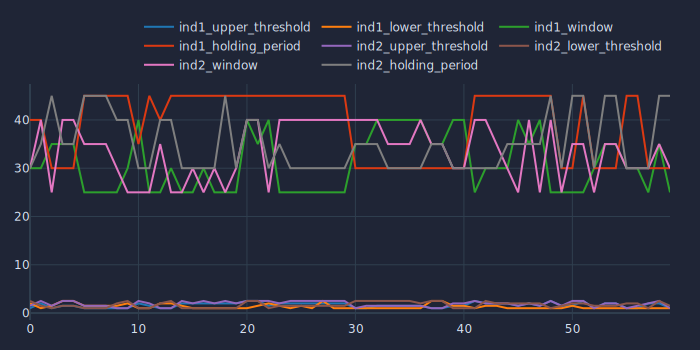

In [ ]:
columns = ['ind1_upper_threshold', 'ind1_lower_threshold', 'ind1_window', 'ind1_holding_period', 'ind2_upper_threshold', 'ind2_lower_threshold', 'ind2_window', 'ind2_holding_period']
pd.DataFrame(in_best_params, columns=columns).vbt.plot().show_svg()

In [ ]:
out_hold_sharpe = simulate_holding(out_price, **pf_kwargs)

print(out_hold_sharpe)

split_idx
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    1.0
33    1.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
45    1.0
46    0.0
47    0.0
48    0.0
49    0.0
50    0.0
51    0.0
52    0.0
53    0.0
54    0.0
55    1.0
56    1.0
57    1.0
58    1.0
59    1.0
Name: win_rate, dtype: float64


In [ ]:
# Simulate all params for out-sample ranges
out_sharpe = simulate_all_params(out_price, **pf_kwargs)

print(out_sharpe)

breakout_1_upper_threshold  breakout_1_lower_threshold  breakout_1_window  breakout_1_holding_period  breakout_2_upper_threshold  breakout_2_lower_threshold  breakout_2_window  breakout_2_holding_period  split_idx
1.0                         1.0                         25                 30                         1.0                         1.0                         25                 35                         0            0.875000
                                                                                                                                                                                                            1            0.888889
                                                                                                                                                                                                            2            0.875000
                                                                                                            

In [ ]:
out_best_index = get_best_index(out_sharpe)

print(out_best_index)
print(out_best_index.shape)

MultiIndex([(1.0, 1.0, 30, 30, 1.0, 1.0, 30, 40,  0),
            (1.0, 1.0, 25, 40, 1.0, 1.0, 30, 40,  1),
            (1.0, 1.0, 25, 40, 1.0, 1.0, 30, 40,  2),
            (1.0, 1.0, 25, 40, 1.0, 2.0, 35, 35,  3),
            (1.0, 1.0, 25, 30, 1.0, 1.0, 40, 30,  4),
            (1.0, 1.0, 25, 40, 1.5, 1.5, 35, 35,  5),
            (1.0, 1.0, 25, 35, 1.0, 1.0, 40, 30,  6),
            (1.0, 1.0, 30, 35, 1.0, 1.0, 40, 30,  7),
            (1.0, 1.0, 35, 35, 1.0, 1.0, 40, 35,  8),
            (2.5, 1.5, 40, 45, 2.5, 2.0, 25, 40,  9),
            (1.0, 1.0, 40, 45, 1.0, 2.0, 35, 30, 10),
            (1.0, 1.0, 40, 45, 1.0, 1.5, 25, 40, 11),
            (2.0, 1.0, 25, 45, 2.0, 1.0, 40, 45, 12),
            (2.0, 1.0, 25, 45, 2.5, 1.0, 35, 30, 13),
            (2.0, 1.0, 25, 45, 2.0, 1.0, 30, 30, 14),
            (1.0, 1.0, 25, 30, 1.0, 1.0, 35, 30, 15),
            (1.0, 1.0, 25, 30, 1.0, 1.0, 35, 30, 16),
            (1.0, 1.5, 25, 40, 2.5, 2.5, 40, 30, 17),
            (1.0, 1.0, 25, 4

In [ ]:
def simulate_best_params(price, 
                        ind1_best_upper_thresholds, 
                        ind1_best_lower_thresholds, 
                        ind1_best_windows, 
                        ind1_best_hold_periods, 
                        ind2_best_upper_thresholds, 
                        ind2_best_lower_thresholds, 
                        ind2_best_windows, 
                        ind2_best_hold_periods, 
                        **kwargs):
    ind1 = breakout_ind.run(
        price,
        upper_threshold=ind1_best_upper_thresholds,
        lower_threshold=ind1_best_lower_thresholds,
        window=ind1_best_windows,
        holding_period=ind1_best_hold_periods,
        per_column=True,
    )
    ind2 = breakout_ind.run(
        price,
        upper_threshold=ind2_best_upper_thresholds,
        lower_threshold=ind2_best_lower_thresholds,
        window=ind2_best_windows,
        holding_period=ind2_best_hold_periods,
        per_column=True,
    )

    entries = ind1.value_crossed_above(0)
    # exits = entries.shift(holding_period).fillna(False)
    exits = ind1.value_crossed_above(1)

    entries_short = ind2.value_crossed_below(0)
    # exits_short = entries_short.shift(holding_period).fillna(False)
    exits_short = ind2.value_crossed_below(-1)

    # Calculate Portfolio
    pf = vbt.Portfolio.from_signals(
        price,
        entries=entries,
        exits=exits,
        short_entries=entries_short,
        short_exits=exits_short,
        **kwargs,
    )
    return pf.trades.win_rate()

In [ ]:
out_price.shape

(300, 60)

In [ ]:
out_test_sharpe = simulate_best_params(out_price, 
                        in_ind1_best_upper_thresholds, 
                        in_ind1_best_lower_thresholds, 
                        in_ind1_best_windows, 
                        in_ind1_best_hold_periods, 
                        in_ind2_best_upper_thresholds, 
                        in_ind2_best_lower_thresholds, 
                        in_ind2_best_windows, 
                        in_ind2_best_hold_periods,
                        **pf_kwargs)

# print(out_test_sharpe.groupby('split_idx').mean())
print(out_test_sharpe)


breakout_upper_threshold  breakout_lower_threshold  breakout_window  breakout_holding_period  breakout_upper_threshold  breakout_lower_threshold  breakout_window  breakout_holding_period  split_idx
1.0                       2.0                       30               40                       1.5                       2.5                       30               30                       0            0.500000
2.0                       1.0                       30               40                       2.5                       1.5                       40               35                       1            0.833333
1.0                       1.5                       35               30                       1.5                       1.0                       25               45                       2            0.600000
1.5                       2.5                       35               30                       2.5                       1.5                       40               35       

In [ ]:
cv_results_df = pd.DataFrame({
    'in_sample_hold': in_hold_sharpe.values,
    'in_sample_median': in_sharpe.groupby('split_idx').median().values,
    'in_sample_best': in_sharpe[in_best_index].values,
    'out_sample_hold': out_hold_sharpe.values,
    'out_sample_median': out_sharpe.groupby('split_idx').median().values,
    'out_sample_test': out_test_sharpe.values,
})

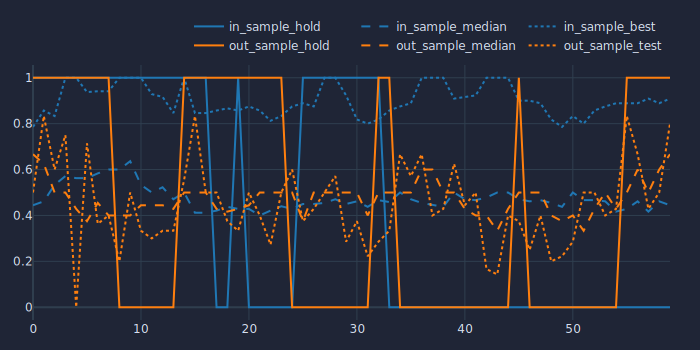

In [ ]:
color_schema = vbt.settings['plotting']['color_schema']

cv_results_df.vbt.plot(
    trace_kwargs=[
        dict(line_color=color_schema['blue']),
        dict(line_color=color_schema['blue'], line_dash='dash'),
        dict(line_color=color_schema['blue'], line_dash='dot'),
        dict(line_color=color_schema['orange']),
        dict(line_color=color_schema['orange'], line_dash='dash'),
        dict(line_color=color_schema['orange'], line_dash='dot')
    ]
).show_svg()

In [ ]:
# output the entire portfolio objects 
def simulate_best_params_output_full_portfoios(price, 
                        ind1_best_upper_thresholds, 
                        ind1_best_lower_thresholds, 
                        ind1_best_windows, 
                        ind1_best_hold_periods, 
                        ind2_best_upper_thresholds, 
                        ind2_best_lower_thresholds, 
                        ind2_best_windows, 
                        ind2_best_hold_periods, 
                        **kwargs):
    ind1 = breakout_ind.run(
        price,
        upper_threshold=ind1_best_upper_thresholds,
        lower_threshold=ind1_best_lower_thresholds,
        window=ind1_best_windows,
        holding_period=ind1_best_hold_periods,
        per_column=True,
    )
    ind2 = breakout_ind.run(
        price,
        upper_threshold=ind2_best_upper_thresholds,
        lower_threshold=ind2_best_lower_thresholds,
        window=ind2_best_windows,
        holding_period=ind2_best_hold_periods,
        per_column=True,
    )

    entries = ind1.value_crossed_above(0)
    # exits = entries.shift(holding_period).fillna(False)
    exits = ind1.value_crossed_above(1)

    entries_short = ind2.value_crossed_below(0)
    # exits_short = entries_short.shift(holding_period).fillna(False)
    exits_short = ind2.value_crossed_below(-1)

    # Calculate Portfolio
    pf = vbt.Portfolio.from_signals(
        price,
        entries=entries,
        exits=exits,
        short_entries=entries_short,
        short_exits=exits_short,
        **kwargs,
    )
    return pf

In [ ]:
out_test_sharpe_full = simulate_best_params_output_full_portfoios(out_price, 
                        in_ind1_best_upper_thresholds, 
                        in_ind1_best_lower_thresholds, 
                        in_ind1_best_windows, 
                        in_ind1_best_hold_periods, 
                        in_ind2_best_upper_thresholds, 
                        in_ind2_best_lower_thresholds, 
                        in_ind2_best_windows, 
                        in_ind2_best_hold_periods,
                        **pf_kwargs)

# print(out_test_sharpe.groupby('split_idx').mean())
print(out_test_sharpe_full)

Portfolio(**Config({
    "wrapper": "<vectorbt.base.array_wrapper.ArrayWrapper object at 0x288373670> of shape (300, 60)",
    "close": "<pandas.core.frame.DataFrame object at 0x2884fef20> of shape (300, 60)",
    "order_records": "<numpy.ndarray object at 0x288cdf150> of shape (586,)",
    "log_records": "<numpy.ndarray object at 0x288cdf270> of shape (0,)",
    "init_cash": "<numpy.ndarray object at 0x288cdde90> of shape (60,)",
    "cash_sharing": false,
    "call_seq": null,
    "fillna_close": null,
    "trades_type": null
}))


In [ ]:
for col in range(0,60):
    print(out_test_sharpe_full.stats(column=col))

Start                                        0
End                                        299
Period                        75 days 00:00:00
Start Value                              100.0
End Value                            20.862887
Total Return [%]                    -79.137113
Benchmark Return [%]                164.207028
Max Gross Exposure [%]                   100.0
Total Fees Paid                            0.0
Max Drawdown [%]                    123.783886
Max Drawdown Duration         65 days 12:00:00
Total Trades                                 2
Total Closed Trades                          2
Total Open Trades                            0
Open Trade PnL                             0.0
Win Rate [%]                              50.0
Best Trade [%]                       15.916948
Worst Trade [%]                     -82.001866
Avg Winning Trade [%]                15.916948
Avg Losing Trade [%]                -82.001866
Avg Winning Trade Duration    10 days 00:00:00
Avg Losing Tr

In [ ]:
out_test_sharpe_full.trades.records_readable